# Generative Adversarial Model in Keras with MNIST data

## 1. it is a learning note of the original post [MNIST Generative Adversaial Model in Keras](https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/) - all credits are for original writers.
## 2. Original GAN Paper - [Generative Advesarial Networks](http://arxiv.org/abs/1406.2661)
## 3. [Ipython Notebook Demostration](https://github.com/osh/KerasGAN)

## What is GAN
- ___A Generative Model___ to generate target outputs from nothing (e.g., pure random noise).
- ___An Adversarial Model___ trained to distringuish a real output (e.g., from nature) and a generated output (from generative model).
- Two models stacked together to be trained in a competative way, so that performances of both are improved.

## Notes for pratical implementations
Some notes taken during my re-implementation of the simple model
1. Adversarial models are usually pretrained to speed up the convergence of both models. 
    - However, if it is overfitted (e.g., by seeing only a specific pattern of data, with a large learning rate), the overfitted adversarial model might block the training of generative model (becsause it is stacked on top of the generative model).
    - In practice I need to be very careful with the ___randomness of mnist data for pretraining adversarial model___ and ___using a relatively small learning rate___ to prevent overfitting.
    - Underfitting adversarial models at pretraining seems to slow down GAN, but less harmful compared to overfitting?
2. The training of generative model is better with a frozen adversarial head (when they are stacked), but since I am not totally confident whether the adversarial is really frozen (there is some confusion about how to using `trainable` to control the model state, e.g., it is inconsistent with `get_configuration()`), I dont know whether this is significant.
    - Using batchNormalization is a key part in generative model training - it speeds up the convergence quite a lot
3. There should be an balance between the learnings (competitions) of geneative and adversarial models
    - If the adversarial model is learning faster, the generative model will have hard time catching up - and even got blocked sometime (not sure why)
    - if the geneative model is learning faster and the adversarial model is not learning enough, both might end with non-satisfactory convergence and either performs well.
    - It's often observed that the error curves of the two models are competing and finally converging to a realatively stable state

## Generative Model
- Generate MNIST images from 100 random numbers
- Model structure:
    - Map random inputs to 200*14*14 feature map
    - Upsample it to desired target size, i.e., 28*28
    - Then apply a series of conv filters (to make it locally smooth?).
    - The final layer is `sigmoid` to make the image between 0 ~ 1
    - BatchNormalization is used across to speed up the convergence

In [1]:
import os
# make it explict and simple to test
os.environ['KERAS_BACKEND'] = 'theano' 
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from IPython import display

%matplotlib inline

In [2]:
from keras.models import Model, Sequential
import keras.backend as K
from keras.layers import Input, BatchNormalization, Flatten
from keras.layers import UpSampling2D, Conv2D, Dropout, Convolution2D
from keras.layers import Reshape, Activation, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets import mnist
from sklearn.utils import shuffle

Using Theano backend.
Using gpu device 0: GeForce GTX 980M (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 5103)


Need to explicitly spell out axis=1 in new version of BatchNormalization in Keras. See [discussions](https://github.com/fchollet/keras/issues/3888). BatchNorm is very important to the performance.

It is important to use BatchNormalization to speed up

In [3]:
nb_filters = 200

gi = Input(shape = (100, ))
go = Dense(nb_filters*14*14, init='glorot_normal')(gi)
## put BN after relu?
go = BatchNormalization(mode=2, axis=1)(go)
go = Activation('relu')(go)

go = Reshape((nb_filters, 14, 14))(go)
# now the right image size
go = UpSampling2D((2, 2))(go)

# filtering, filtering to make it has 
# enough capability to learn
go = Conv2D(nb_filters / 2, 3, 3, 
            border_mode='same')(go)
go = BatchNormalization(mode=2, axis=1)(go)
go = Activation('relu')(go)

go = Conv2D(nb_filters / 4, 3, 3, 
            border_mode='same')(go)
go = BatchNormalization(mode=2, axis=1)(go)
go = Activation('relu')(go)

go = Conv2D(1, 1, 1, 
            border_mode='same', activation='sigmoid')(go)

generative_model = Model(input=gi, output=go)
generative_model.compile(loss="binary_crossentropy", optimizer='adam')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 39200)         3959200     input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNormal(None, 39200)         78400       dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 39200)         0           batchnormalization_1[0][0]       
___________________________________________________________________________________________

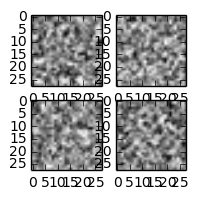

In [4]:
## test generator
print generative_model.summary()
images = generative_model.predict(np.random.uniform(0, 1, (4, 100)))
fig, axes = plt.subplots(2, 2, figsize = (2, 2))
axes = axes.ravel()
for ax, img in zip(axes, images):
    print img.shape
    ax.imshow(img[0], cmap=plt.cm.gray)

## Adversarial Model
- Generally it can be anything that does good job on classifying real and faked images
- Use a simple CNN for this purpose
- make sure the adversarial model won't overfit easily, e.g., by setting a relatively small learning rate. Otherwise the generative model seems to not be able to learn

In [5]:
ai = Input(shape=(1, 28, 28))
ao = Conv2D(256, 3, 3,
            border_mode='same', 
            activation='relu')(ai)
ao = Dropout(0.5)(ao)
ao = Conv2D(128, 3, 3,
            border_mode='same', 
            activation='relu')(ao)
ao = Dropout(0.5)(ao)
ao = Conv2D(64, 3, 3,
            border_mode='same', 
            activation='relu')(ao)
ao = Dropout(0.2)(ao)

ao = Flatten()(ao)
ao = Dense(128, activation='relu')(ao)
ao = Dropout(0.5)(ao)
ao = Dense(1, activation='sigmoid')(ao)

adversarial_model = Model(input=ai, output=ao)
adversarial_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5))

In [6]:
# test adversarial_model
print adversarial_model.summary()
# 0.5 means it is not sure about anything
adversarial_model.predict(images)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 256, 28, 28)   2560        input_2[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 256, 28, 28)   0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 128, 28, 28)   295040      dropout_1[0][0]                  
___________________________________________________________________________________________

array([[ 0.49697122],
       [ 0.49390838],
       [ 0.49874809],
       [ 0.49443501]], dtype=float32)

## Generative Adversarial Network Model as a Stack

In [7]:
def toggle_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [8]:
toggle_trainable(adversarial_model, False)

gan_input = Input(shape = (100,))
h = generative_model(gan_input)
gan_output = adversarial_model(h)

# adversarial_model.trainable = False
# for layer in adversarial_model.layers:
#     layer.trainable = False
    
gan_model = Model(input = gan_input, output = gan_output)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5e-4))

# adversarial_model.trainable = True
# for layer in adversarial_model.layers:
#     layer.trainable = True



In [9]:
# test gan model
seed = np.random.uniform(0, 1, (4, 100))
image_labels = gan_model.predict(seed)
print image_labels.shape
## all faked images - output all zeros
print image_labels

(4, 1)
[[ 0.49557543]
 [ 0.49604407]
 [ 0.50045836]
 [ 0.496326  ]]


## pretrain the adversarial model
Quoted from original post
```
We pre-train the discriminative model by generating a handful of random images using the untrained generative model, concatenating them with an equal number of real images of digits, labeling them appropriately, and then fitting until we reach a relatively stable loss value which takes 1 epoch over 20,000 examples.  This is an important step which should not be skipped — pre-training accelerates the GAN massively and I was not able to achieve convergence without it (possibly due to impatience).
```

In [10]:
nb_samples = 10000

In [11]:
## load real images from mnist data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
print train_x.shape, test_x.shape
print train_y.shape, test_y.shape
real_images = np.concatenate([train_x, test_x], axis=0)
real_images = np.expand_dims(real_images, axis = 1).astype(np.float32)
real_images = real_images / 255.
i = np.random.randint(0, real_images.shape[0], nb_samples)
#real_images = real_images[:nb_samples]
real_images = real_images[i,...]
print real_images.shape
print real_images.min(), real_images.max()

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)
(10000, 1, 28, 28)
0.0 1.0


In [12]:
## generate faked images from untrained generative model
seeds = np.random.uniform(0, 1, (nb_samples, 100))
faked_images = generative_model.predict(seeds)
print faked_images.shape
print faked_images.min(), faked_images.max()

(10000, 1, 28, 28)
0.0225055 0.984333


In [13]:
## generate train data
x = np.concatenate([real_images, faked_images], axis=0)
# real images - 1, faked images - 0
y = np.repeat([1, 0], nb_samples).astype(np.float32)
#y = to_categorical(y)
y = y.reshape((-1, 1))
# randomly shuffle the data
x, y = shuffle(x, y)
print x.shape, y.shape

(20000, 1, 28, 28) (20000, 1)


In [14]:
## pretrain adversarial model
toggle_trainable(adversarial_model, True)

adversarial_model.fit(x, y, nb_epoch=1,
                      batch_size=128)

Epoch 1/1
20000/20000 [==============================] - 31s - loss: 0.1597    


make sure it won't overfit easily

In [15]:
## check pretrained adversarial model
yhat = adversarial_model.predict(x)
print "accuracy:", np.mean( (yhat[:, 0] > 0.5) == y[:,0] )
#print "accuracy:", np.mean( np.argmax(yhat) == np.argmax(y) )

accuracy: 1.0


## training of GAN
Typically, it involves iterations of 3 main steps,

1. Generate images by generative_model
2. Train(update) adversarial_model by new generated images and real ones
3. Update GAN (with adversarial frozen) with NOISE and REAL_IMAGE_LABELS

To do so, we need to make the adversarial_model trainable during its own update and non_trainable when used within GAN. This can be done by setting the layers (or model's) traiable parameter to False. I am still puzzled by the usage of it, so will stick with the old way - excplitly turning off and on trainable parameters every time. See [#3881](https://github.com/fchollet/keras/issues/3881) for details

In [16]:
## helper functions

def real_image_generator(size=64):
    (train_x, train_y), (test_x, test_y) = mnist.load_data()
    real_images = np.concatenate([train_x, test_x], axis=0)
    real_images = np.expand_dims(real_images, axis = 1).astype(np.float32)
    real_images = real_images / 255.
    N = real_images.shape[0]
    while True:
        i = np.random.randint(0, N, size)
        yield real_images[i,...]
        
def noise_generator(size=64):
    while True:
        seeds = np.random.uniform(0, 1, size=(size, 100)).astype(np.float32)
        yield seeds
        
def fake_image_generator(size=64):
    noise = noise_generator(size)
    while True:
        seeds = noise.next()
        fake_images = generative_model.predict(seeds)
        yield fake_images
        
def make_adversarial_data(real_images, faked_images):
    images = np.concatenate([real_images, faked_images], axis=0)
    labels = np.ones(images.shape[0])
    labels[real_images.shape[0]:] = 0
    labels = labels.reshape((-1, 1)).astype(np.float32)
    #labels = to_categorical(labels)
    images, labels = shuffle(images, labels)
    return images, labels

def make_gan_data(noise):
    labels = np.ones(noise.shape[0]).astype(np.float32)
    #labels = to_categorical(labels)
    labels = labels.reshape((-1, 1))
    noise, labels = shuffle(noise, labels)
    return noise, labels

In [17]:
## test gan trainable
noise = noise_generator(32).next()
x, y = make_gan_data(noise)
#y = np.zeros_like(y)

#toggle_trainable(adversarial_model, False)
gan_model.fit(x, y, nb_epoch=3)

Epoch 1/3
32/32 [==============================] - 0s - loss: 6.9822
Epoch 2/3
32/32 [==============================] - 0s - loss: 0.8618
Epoch 3/3
32/32 [==============================] - 0s - loss: 0.1234


In [18]:
## test real_image generator
reals = real_image_generator().next()
assert reals.shape == (64, 1, 28, 28)
assert np.all(reals >= 0.) and np.all(reals <= 1.0)

## test fake_image generator
fakes = fake_image_generator().next()
assert fakes.shape == (64, 1, 28, 28)
assert np.all(fakes >= 0.) and np.all(fakes <= 1.0)

## test make_adversarial_data
imgs, labls = make_adversarial_data(reals, fakes)
assert imgs.shape == (128, 1, 28, 28)
assert labls.shape == (128, 1)
assert np.all((labls == 0) | (labls == 1))

## test make_gae_data
noise = noise_generator().next()
noise, labls = make_gan_data(noise)
assert noise.shape == (64, 100)
assert labls.shape == (64, 1)
assert np.all(labls == 1) # fake it as real

In [19]:
gan_logs, adversarial_logs = [], []

def plot_loss(losses):
    plt.figure(figsize=(4, 4))
    for name, values in losses.items():
        plt.plot(values, label = name)
    plt.legend(loc="best")
    plt.show()
    
def plot_generated():
    noise = np.random.uniform(0,1,size=[9,100])
    generated_images = generative_model.predict(noise)
    
    fig, axes = plt.subplots(3, 3, figsize=(3, 3))
    axes = axes.ravel()
    for ax, img in zip(axes, generated_images):
        ax.imshow(img[0, :, :], cmap = plt.cm.gray)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

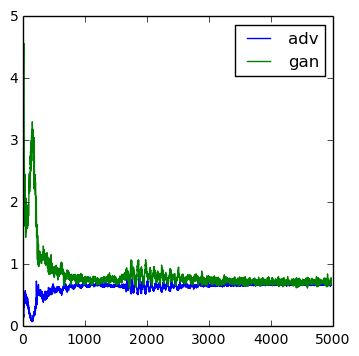

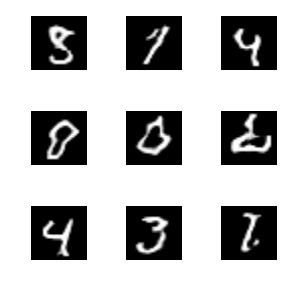

100%|██████████| 2000/2000 [16:18<00:00,  2.48it/s]


In [247]:
nb_epoch = 2000
batch_size = 64

g_real_images = real_image_generator(size=batch_size)
g_fake_images = fake_image_generator(size=batch_size)
g_noise = noise_generator(size=batch_size)

for i in tqdm.tqdm(range(nb_epoch)):
    
    # train adversarial_model
    
    #toggle_trainable(adversarial_model, True)
    real_images = g_real_images.next()
    fake_images = g_fake_images.next()
    x, y = make_adversarial_data(real_images, fake_images)
    
    a_loss = adversarial_model.train_on_batch(x, y)
    adversarial_logs.append(a_loss)
    
    # train GAN
    #toggle_trainable(adversarial_model, False)
    noise = g_noise.next()
    x, y = make_gan_data(noise)
    
    g_loss = gan_model.train_on_batch(x, y)
    gan_logs.append(g_loss)
    
    if i % 25 == 0:
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plot_loss({"gan": gan_logs
                  , "adv": adversarial_logs})
        plot_generated()

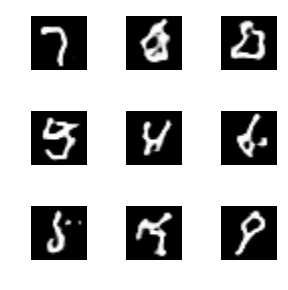

In [250]:
plot_generated()

## Some Observations:
1. Never overfit the adversarial model, because it seems that once it is overfitted, it will be very hard for generative model to learn anything on new cases - the gradient won't propagate? 
2. It is important to pick a balance between the learning rates between the generative and adverserial models. e.g.,
    - if generative is not learning as fast as adversrial, its error will increase a lot, speically at the beginning, which heavily decrease the convergence rate (or never converge at all)
    - if adversirial learning rate is too slow, it might be fooled easily by the generative model, which terminates the learning early and generates unsatisactory results 
3. It seems that the exact models used are less critical